In [46]:
import matplotlib.pyplot as plt
import pde
import numpy as np
import torch
import pandas as pd
from torch.nn import functional as F


from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

plt.rcParams['figure.figsize'] = [10, 10]

In [53]:
def solveEquationPYPDE(variable, eq, ic="2/cosh(x)**2", xrange=None, yrange=None, points=150, trange=0.4):
    #initialize xrange
    if xrange is None:
        xrange = [-pi, pi]
    
    #eq is passed in as a string with x as the dependent variable
    eq = pde.PDE({variable: eq})
    
    if yrange is not None:
        grid = pde.grids.CartesianGrid([xrange, yrange], [points], periodic=[True, True])
    else:
        grid = pde.grids.CartesianGrid([xrange], [points],  periodic=True)
    
    field = pde.ScalarField.from_expression(grid, ic)

    storage = pde.MemoryStorage()
    trackers = ['progress', storage.tracker(interval=0.001)]
    #bc = ["periodic", {'derivative': 'periodic'}]
    #field /= np.sqrt(field.to_scalar('norm_squared').integral.real)

    solver = pde.ExplicitSolver(eq, backend='numba' ,scheme='runge-kutta', adaptive=True, tolerance=1e-9)
    controller = pde.Controller(solver, t_range=trange, tracker=trackers)
    solution = controller.run(field, dt=1e-4)
    
    return field, storage

In [54]:
s1, st1 = solveEquationPYPDE('phi', f"- 6 * phi * d_dx(phi) - laplace(d_dx(phi))")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 0.4/0.4 [00:16<00:00, 40.61s/it]


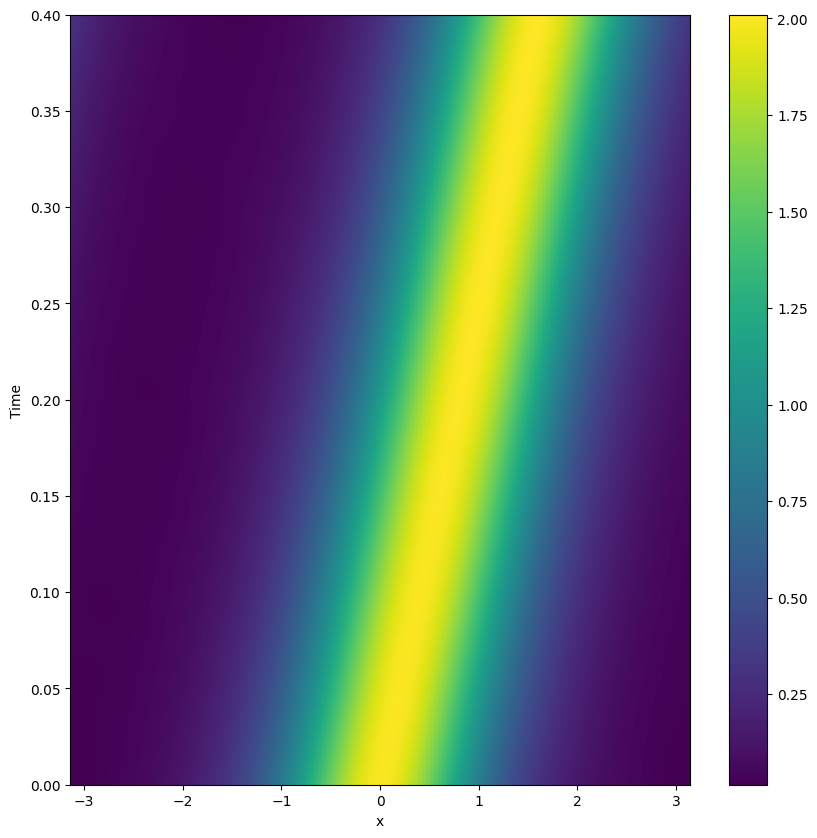

In [55]:
pde.plot_kymograph(st1)

In [56]:
x = s1.get_line_data()['data_x'].reshape(-1,1) # X x 1
t = np.array(st1.times).reshape(-1,1) # T x 1
x_grid, t_grid = np.meshgrid(x, t)


phi = np.array(st1.data)
#u = np.real(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)   #.flatten()[:,None]
#v = np.imag(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)  #.flatten()[:,None]

#plt.pcolormesh(x_grid, t_grid, np.sqrt(u**2 + v**2))

##Generate the two indices
idx1 = np.random.choice(x_grid.shape[0], 105, replace=False)
idx1 = np.sort(idx1)
idx2 = np.random.choice(x_grid.shape[1], 100, replace=False)
idx2 = np.sort(idx2)

def gen_train(grid):
    grid_new = grid[idx1]
    grid_new = grid_new[:,idx2]
    return grid_new
    
x_train, t_train, phi_train = gen_train(x_grid), gen_train(t_grid), gen_train(phi)

## attempt to plot
##plt.pcolormesh(x_train, t_train, phi_train)

In [40]:
## reshape to feed into model
x_train = x_train.flatten()[:,None]
t_train = t_train.flatten()[:,None]

phi_train = phi_train.flatten()[:,None]
print(x_train.shape, t_train.shape, phi_train.shape)

(10500, 1) (10500, 1) (10500, 1)


In [41]:
## boilerplate stuff for GPU...
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

class PINN():
    def __init__(self, x, t, phi):
        self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True, device=device)
        self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True, device=device)
        
        self.phi = torch.tensor(phi, dtype=torch.float32, device=device)
        
        self.null = torch.zeros((self.x.shape[0],1), device=device)

        self.net_init()
        #self.optim = torch.optim.LBFGS(self.net.parameters(),
        #                               lr=0.01,
        #                               max_iter=50000,
        #                               max_eval=50000,
        #                               history_size=50,
        #                               tolerance_grad=1e-8,
        #                               tolerance_change=0.5 * np.finfo(float).eps,
        #                               line_search_fn='strong_wolfe'
        #                              )

        self.optim = torch.optim.Adam(self.net.parameters(), lr=1e-4)
        
        self.mse = torch.nn.MSELoss()
        self.ls = 0
        self.step = 0
        print(self.x.shape, self.t.shape, self.phi.shape)
    
    def net_init(self, dDim=256, act=torch.nn.Tanh):
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, 1)
        )
        self.net.to(device)
    
    def func(self, x, t):
        phi = self.net(torch.hstack((x, t)))

        phi_t = torch.autograd.grad(phi, t, torch.ones_like(phi), create_graph=True)[0]
        phi_x = torch.autograd.grad(phi, x, torch.ones_like(phi), create_graph=True)[0]
        phi_xx = torch.autograd.grad(phi_x, x, torch.ones_like(phi_x), create_graph=True)[0]
        phi_xxx = torch.autograd.grad(phi_xx, x, torch.ones_like(phi_xx), create_graph=True)[0]

        f_phi = phi_t + 6 * phi * phi_x + phi_xxx

        return phi, f_phi
        
    def closure(self):
        self.optim.zero_grad(set_to_none=True)

        phi_pred, f_phi_pred = self.func(self.x, self.t)
        
        phi_loss = self.mse(phi_pred, self.phi)
        f_phi_loss = self.mse(f_phi_pred, self.null)
        print(f"Data loss: {phi_loss.item()}, Function loss: {f_phi_loss.item()}")
        self.ls = phi_loss + f_phi_loss
        self.ls.backward()

        ## Show some graphs and stuff if step % 500 == 0
        
        print(f"Step: {self.step}, Loss: {self.ls}")
        self.step += 1
        return self.ls

    def train(self):
        self.net.train()
        for i in range(5000):
            self.optim.step(self.closure)

In [42]:
kdv = PINN(x_train, t_train, phi_train)

/home/gallirium/dostNN/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([10500, 1]) torch.Size([10500, 1]) torch.Size([10500, 1])


In [43]:
kdv.train()

Data loss: 0.7677629590034485, Function loss: 0.00010391690739197657
Step: 0, Loss: 0.767866849899292
Data loss: 0.7226406931877136, Function loss: 9.284700354328379e-05


/home/gallirium/dostNN/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [10500, 1], strides() = [1, 0]
param.sizes() = [10500, 1], strides() = [1, 0] (Triggered internally at ../torch/csrc/autograd/functions/accumulate_grad.h:219.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step: 1, Loss: 0.7227335572242737
Data loss: 0.6797754764556885, Function loss: 0.00018965166236739606
Step: 2, Loss: 0.6799651384353638
Data loss: 0.6386188268661499, Function loss: 0.0004593803605530411
Step: 3, Loss: 0.6390781998634338
Data loss: 0.5987187623977661, Function loss: 0.0010472032008692622
Step: 4, Loss: 0.599765956401825
Data loss: 0.559819221496582, Function loss: 0.0022025792859494686
Step: 5, Loss: 0.562021791934967
Data loss: 0.5218454003334045, Function loss: 0.004305982496589422
Step: 6, Loss: 0.5261513590812683
Data loss: 0.48493069410324097, Function loss: 0.007892830297350883
Step: 7, Loss: 0.4928235113620758
Data loss: 0.44941702485084534, Function loss: 0.013627279549837112
Step: 8, Loss: 0.46304431557655334
Data loss: 0.4158943295478821, Function loss: 0.022184183821082115
Step: 9, Loss: 0.43807852268218994
Data loss: 0.3851945102214813, Function loss: 0.0338548980653286
Step: 10, Loss: 0.4190494120121002
Data loss: 0.3583681583404541, Function loss: 0.0479

In [44]:
x_axis = torch.linspace(-pi, 2*pi, 100)
t_axis = torch.linspace(0, 0.5, 100)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

phi = kdv.net(xt_pairs).reshape((100,100)).detach().cpu()

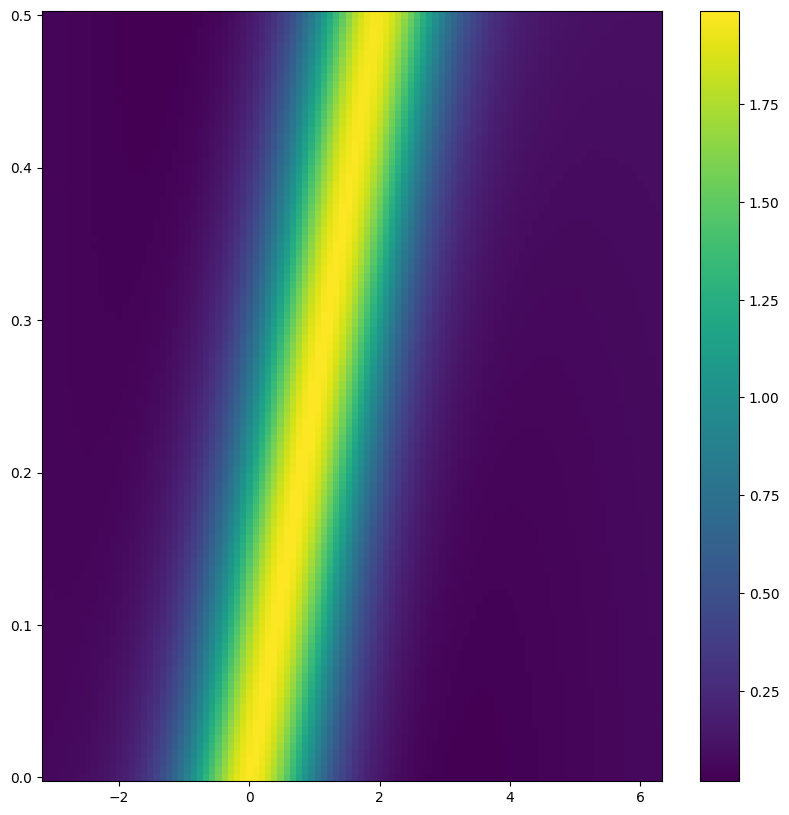

In [45]:
plt.pcolormesh(x_grid, t_grid, phi)
plt.colorbar()
plt.show()

In [ ]:
## CHECK IF THE TRAINING DATA IS ALIGNED

xx = x_train.flatten()
tt = t_train.flatten()
z = phi_train.flatten()

ax = plt.axes(projection='3d')
ax.view_init(90, -90, 0)
ax.plot_trisurf(xx, tt, z, cmap='jet')

In [ ]:
kdv.closure()

In [ ]:
print(x_train.shape, t_train.shape, phi_train.shape)

In [11]:
torch.hstack((kdv.x, kdv.t)).shape

torch.Size([10500, 2])

256512